## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2021-05-11 14:50:13--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.77.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.77.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  59.7MB/s    in 5.5s    

2021-05-11 14:50:18 (58.6 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=136, bias=True)
  (dropout): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

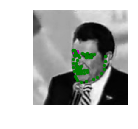

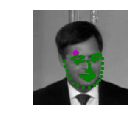

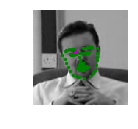

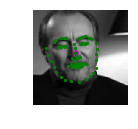

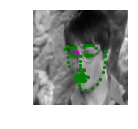

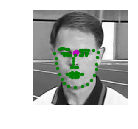

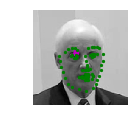

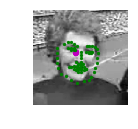

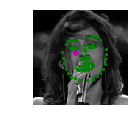

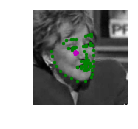

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [17]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(),lr=0.0005)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [18]:
# train your network
n_epochs = 20 #tart small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
from workspace_utils import active_session


with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.043015293404459955
Epoch: 1, Batch: 20, Avg. Loss: 0.03705541733652353
Epoch: 1, Batch: 30, Avg. Loss: 0.027841830067336558
Epoch: 1, Batch: 40, Avg. Loss: 0.025899129547178747
Epoch: 1, Batch: 50, Avg. Loss: 0.030314455274492502
Epoch: 1, Batch: 60, Avg. Loss: 0.03755649970844388
Epoch: 1, Batch: 70, Avg. Loss: 0.03691325932741165
Epoch: 1, Batch: 80, Avg. Loss: 0.022470615711063145
Epoch: 1, Batch: 90, Avg. Loss: 0.04390251133590937
Epoch: 1, Batch: 100, Avg. Loss: 0.03259440148249269
Epoch: 1, Batch: 110, Avg. Loss: 0.02488478971645236
Epoch: 1, Batch: 120, Avg. Loss: 0.03714103447273374
Epoch: 1, Batch: 130, Avg. Loss: 0.02362676626071334
Epoch: 1, Batch: 140, Avg. Loss: 0.03380657164379954
Epoch: 1, Batch: 150, Avg. Loss: 0.025940191745758057
Epoch: 1, Batch: 160, Avg. Loss: 0.02506005289033055
Epoch: 1, Batch: 170, Avg. Loss: 0.028197325207293032
Epoch: 1, Batch: 180, Avg. Loss: 0.031725662387907506
Epoch: 1, Batch: 190, Avg. Loss: 0.035960311908

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.025912987999618053
Epoch: 2, Batch: 20, Avg. Loss: 0.036236413195729254
Epoch: 2, Batch: 30, Avg. Loss: 0.027519178204238416
Epoch: 2, Batch: 40, Avg. Loss: 0.02741832509636879
Epoch: 2, Batch: 50, Avg. Loss: 0.028192955628037454
Epoch: 2, Batch: 60, Avg. Loss: 0.025489252433180808
Epoch: 2, Batch: 70, Avg. Loss: 0.030198868922889234
Epoch: 2, Batch: 80, Avg. Loss: 0.02642909176647663
Epoch: 2, Batch: 90, Avg. Loss: 0.024666156712919475
Epoch: 2, Batch: 100, Avg. Loss: 0.037014950159937145
Epoch: 2, Batch: 110, Avg. Loss: 0.030387595295906067
Epoch: 2, Batch: 120, Avg. Loss: 0.023086421098560093
Epoch: 2, Batch: 130, Avg. Loss: 0.033994180895388124
Epoch: 2, Batch: 140, Avg. Loss: 0.02451405543833971
Epoch: 2, Batch: 150, Avg. Loss: 0.04363918919116259
Epoch: 2, Batch: 160, Avg. Loss: 0.037226577568799255
Epoch: 2, Batch: 170, Avg. Loss: 0.02268413584679365
Epoch: 2, Batch: 180, Avg. Loss: 0.037302355747669935
Epoch: 2, Batch: 190, Avg. Loss: 0.0263584

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.024429485201835632
Epoch: 3, Batch: 20, Avg. Loss: 0.03642437532544136
Epoch: 3, Batch: 30, Avg. Loss: 0.029049400612711905
Epoch: 3, Batch: 40, Avg. Loss: 0.027898027375340462
Epoch: 3, Batch: 50, Avg. Loss: 0.023790072090923785
Epoch: 3, Batch: 60, Avg. Loss: 0.020265175309032202
Epoch: 3, Batch: 70, Avg. Loss: 0.03499213419854641
Epoch: 3, Batch: 80, Avg. Loss: 0.028837733995169403
Epoch: 3, Batch: 90, Avg. Loss: 0.034303431306034325
Epoch: 3, Batch: 100, Avg. Loss: 0.03154066549614072
Epoch: 3, Batch: 110, Avg. Loss: 0.024396502785384654
Epoch: 3, Batch: 120, Avg. Loss: 0.03206432741135359
Epoch: 3, Batch: 130, Avg. Loss: 0.030308394320309164
Epoch: 3, Batch: 140, Avg. Loss: 0.03067140756174922
Epoch: 3, Batch: 150, Avg. Loss: 0.02651990819722414
Epoch: 3, Batch: 160, Avg. Loss: 0.0389504162594676
Epoch: 3, Batch: 170, Avg. Loss: 0.033770705573260784
Epoch: 3, Batch: 180, Avg. Loss: 0.04266076609492302
Epoch: 3, Batch: 190, Avg. Loss: 0.03543016109

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.029771313164383174
Epoch: 4, Batch: 20, Avg. Loss: 0.030158344935625792
Epoch: 4, Batch: 30, Avg. Loss: 0.01843324303627014
Epoch: 4, Batch: 40, Avg. Loss: 0.034059402719140056
Epoch: 4, Batch: 50, Avg. Loss: 0.027877039276063442
Epoch: 4, Batch: 60, Avg. Loss: 0.03590023750439286
Epoch: 4, Batch: 70, Avg. Loss: 0.02486533522605896
Epoch: 4, Batch: 80, Avg. Loss: 0.025041056890040637
Epoch: 4, Batch: 90, Avg. Loss: 0.030704546999186278
Epoch: 4, Batch: 100, Avg. Loss: 0.03561770832166076
Epoch: 4, Batch: 110, Avg. Loss: 0.030409150384366514
Epoch: 4, Batch: 120, Avg. Loss: 0.033518159110099074
Epoch: 4, Batch: 130, Avg. Loss: 0.025359772518277167
Epoch: 4, Batch: 140, Avg. Loss: 0.036463154386729
Epoch: 4, Batch: 150, Avg. Loss: 0.027536175958812237
Epoch: 4, Batch: 160, Avg. Loss: 0.041865503508597614
Epoch: 4, Batch: 170, Avg. Loss: 0.035771626979112625
Epoch: 4, Batch: 180, Avg. Loss: 0.024019500613212584
Epoch: 4, Batch: 190, Avg. Loss: 0.030338216

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.030074802786111833
Epoch: 5, Batch: 20, Avg. Loss: 0.026026951055973767
Epoch: 5, Batch: 30, Avg. Loss: 0.02284407988190651
Epoch: 5, Batch: 40, Avg. Loss: 0.027594782784581183
Epoch: 5, Batch: 50, Avg. Loss: 0.017807288002222775
Epoch: 5, Batch: 60, Avg. Loss: 0.038596722204238175
Epoch: 5, Batch: 70, Avg. Loss: 0.026591182872653007
Epoch: 5, Batch: 80, Avg. Loss: 0.03278579451143741
Epoch: 5, Batch: 90, Avg. Loss: 0.038013850897550584
Epoch: 5, Batch: 100, Avg. Loss: 0.021612419467419385
Epoch: 5, Batch: 110, Avg. Loss: 0.03382787425071001
Epoch: 5, Batch: 120, Avg. Loss: 0.02728345599025488
Epoch: 5, Batch: 130, Avg. Loss: 0.030055912770330907
Epoch: 5, Batch: 140, Avg. Loss: 0.03588772676885128
Epoch: 5, Batch: 150, Avg. Loss: 0.022559541463851928
Epoch: 5, Batch: 160, Avg. Loss: 0.028956376016139984
Epoch: 5, Batch: 170, Avg. Loss: 0.026875490695238112
Epoch: 5, Batch: 180, Avg. Loss: 0.02878589481115341
Epoch: 5, Batch: 190, Avg. Loss: 0.02425460

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.028613791335374117
Epoch: 6, Batch: 20, Avg. Loss: 0.019614052772521973
Epoch: 6, Batch: 30, Avg. Loss: 0.02486726185306907
Epoch: 6, Batch: 40, Avg. Loss: 0.03246497232466936
Epoch: 6, Batch: 50, Avg. Loss: 0.036767429765313865
Epoch: 6, Batch: 60, Avg. Loss: 0.0258719926699996
Epoch: 6, Batch: 70, Avg. Loss: 0.027154777199029922
Epoch: 6, Batch: 80, Avg. Loss: 0.03362576207146049
Epoch: 6, Batch: 90, Avg. Loss: 0.02233601436018944
Epoch: 6, Batch: 100, Avg. Loss: 0.0439675385132432
Epoch: 6, Batch: 110, Avg. Loss: 0.03179984577000141
Epoch: 6, Batch: 120, Avg. Loss: 0.026289445254951714
Epoch: 6, Batch: 130, Avg. Loss: 0.02495759418234229
Epoch: 6, Batch: 140, Avg. Loss: 0.03799518495798111
Epoch: 6, Batch: 150, Avg. Loss: 0.03319685375317931
Epoch: 6, Batch: 160, Avg. Loss: 0.023235851991921665
Epoch: 6, Batch: 170, Avg. Loss: 0.03466876493766904
Epoch: 6, Batch: 180, Avg. Loss: 0.03657157951965928
Epoch: 6, Batch: 190, Avg. Loss: 0.0200994660146534

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.025568942446261643
Epoch: 7, Batch: 20, Avg. Loss: 0.06354354303330183
Epoch: 7, Batch: 30, Avg. Loss: 0.021955525595694782
Epoch: 7, Batch: 40, Avg. Loss: 0.032489845901727675
Epoch: 7, Batch: 50, Avg. Loss: 0.027878124732524157
Epoch: 7, Batch: 60, Avg. Loss: 0.030724234879016876
Epoch: 7, Batch: 70, Avg. Loss: 0.022169670928269623
Epoch: 7, Batch: 80, Avg. Loss: 0.02774851433932781
Epoch: 7, Batch: 90, Avg. Loss: 0.03812616914510727
Epoch: 7, Batch: 100, Avg. Loss: 0.024669469986110925
Epoch: 7, Batch: 110, Avg. Loss: 0.03584744427353144
Epoch: 7, Batch: 120, Avg. Loss: 0.03453641515225172
Epoch: 7, Batch: 130, Avg. Loss: 0.025485297664999962
Epoch: 7, Batch: 140, Avg. Loss: 0.03096444020047784
Epoch: 7, Batch: 150, Avg. Loss: 0.02520202100276947
Epoch: 7, Batch: 160, Avg. Loss: 0.03081992231309414
Epoch: 7, Batch: 170, Avg. Loss: 0.03186028078198433
Epoch: 7, Batch: 180, Avg. Loss: 0.03150483537465334
Epoch: 7, Batch: 190, Avg. Loss: 0.030809881072

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.0275616642087698
Epoch: 8, Batch: 20, Avg. Loss: 0.029234903398901224
Epoch: 8, Batch: 30, Avg. Loss: 0.04009611438959837
Epoch: 8, Batch: 40, Avg. Loss: 0.026796722505241632
Epoch: 8, Batch: 50, Avg. Loss: 0.03929454144090414
Epoch: 8, Batch: 60, Avg. Loss: 0.0267036747187376
Epoch: 8, Batch: 70, Avg. Loss: 0.03191471230238676
Epoch: 8, Batch: 80, Avg. Loss: 0.0319237444549799
Epoch: 8, Batch: 90, Avg. Loss: 0.030469565745443107
Epoch: 8, Batch: 100, Avg. Loss: 0.029846089612692594
Epoch: 8, Batch: 110, Avg. Loss: 0.027129570581018926
Epoch: 8, Batch: 120, Avg. Loss: 0.03962562400847673
Epoch: 8, Batch: 130, Avg. Loss: 0.025959667935967445
Epoch: 8, Batch: 140, Avg. Loss: 0.024444299936294555
Epoch: 8, Batch: 150, Avg. Loss: 0.02581720855087042
Epoch: 8, Batch: 160, Avg. Loss: 0.021449230890721083
Epoch: 8, Batch: 170, Avg. Loss: 0.031746411323547365
Epoch: 8, Batch: 180, Avg. Loss: 0.037829138711094855
Epoch: 8, Batch: 190, Avg. Loss: 0.0406530339270

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.024034134671092035
Epoch: 9, Batch: 20, Avg. Loss: 0.028120076470077037
Epoch: 9, Batch: 30, Avg. Loss: 0.021406716108322142
Epoch: 9, Batch: 40, Avg. Loss: 0.027145432215183972
Epoch: 9, Batch: 50, Avg. Loss: 0.03401609370484948
Epoch: 9, Batch: 60, Avg. Loss: 0.03302304837852717
Epoch: 9, Batch: 70, Avg. Loss: 0.03838400654494763
Epoch: 9, Batch: 80, Avg. Loss: 0.025208217091858387
Epoch: 9, Batch: 90, Avg. Loss: 0.024173748679459095
Epoch: 9, Batch: 100, Avg. Loss: 0.03624809347093105
Epoch: 9, Batch: 110, Avg. Loss: 0.027127019688487054
Epoch: 9, Batch: 120, Avg. Loss: 0.037820531986653805
Epoch: 9, Batch: 130, Avg. Loss: 0.03186513986438513
Epoch: 9, Batch: 140, Avg. Loss: 0.022796818427741526
Epoch: 9, Batch: 150, Avg. Loss: 0.023224883526563645
Epoch: 9, Batch: 160, Avg. Loss: 0.03752112230286002
Epoch: 9, Batch: 170, Avg. Loss: 0.024760105088353156
Epoch: 9, Batch: 180, Avg. Loss: 0.03578840531408787
Epoch: 9, Batch: 190, Avg. Loss: 0.025182173

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.02664290936663747
Epoch: 10, Batch: 20, Avg. Loss: 0.03726437920704484
Epoch: 10, Batch: 30, Avg. Loss: 0.021064302418380976
Epoch: 10, Batch: 40, Avg. Loss: 0.0294161893427372
Epoch: 10, Batch: 50, Avg. Loss: 0.03058078931644559
Epoch: 10, Batch: 60, Avg. Loss: 0.037269001733511685
Epoch: 10, Batch: 70, Avg. Loss: 0.021226343512535096
Epoch: 10, Batch: 80, Avg. Loss: 0.02920871423557401
Epoch: 10, Batch: 90, Avg. Loss: 0.02345998752862215
Epoch: 10, Batch: 100, Avg. Loss: 0.03206547219306231
Epoch: 10, Batch: 110, Avg. Loss: 0.02488196352496743
Epoch: 10, Batch: 120, Avg. Loss: 0.02178664430975914
Epoch: 10, Batch: 130, Avg. Loss: 0.03668211633339524
Epoch: 10, Batch: 140, Avg. Loss: 0.04726764764636755
Epoch: 10, Batch: 150, Avg. Loss: 0.02644335348159075
Epoch: 10, Batch: 160, Avg. Loss: 0.03806640431284904
Epoch: 10, Batch: 170, Avg. Loss: 0.031846409756690265
Epoch: 10, Batch: 180, Avg. Loss: 0.0329250599257648
Epoch: 10, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.03231389541178942
Epoch: 11, Batch: 20, Avg. Loss: 0.037533152662217614
Epoch: 11, Batch: 30, Avg. Loss: 0.02547128787264228
Epoch: 11, Batch: 40, Avg. Loss: 0.023986569978296755
Epoch: 11, Batch: 50, Avg. Loss: 0.0190884948708117
Epoch: 11, Batch: 60, Avg. Loss: 0.027046594861894847
Epoch: 11, Batch: 70, Avg. Loss: 0.021070350613445043
Epoch: 11, Batch: 80, Avg. Loss: 0.02595872925594449
Epoch: 11, Batch: 90, Avg. Loss: 0.02469546515494585
Epoch: 11, Batch: 100, Avg. Loss: 0.02644510343670845
Epoch: 11, Batch: 110, Avg. Loss: 0.02989759314805269
Epoch: 11, Batch: 120, Avg. Loss: 0.02788037769496441
Epoch: 11, Batch: 130, Avg. Loss: 0.02383429016917944
Epoch: 11, Batch: 140, Avg. Loss: 0.03284119376912713
Epoch: 11, Batch: 150, Avg. Loss: 0.021535298135131598
Epoch: 11, Batch: 160, Avg. Loss: 0.03638181136921048
Epoch: 11, Batch: 170, Avg. Loss: 0.023808703757822514
Epoch: 11, Batch: 180, Avg. Loss: 0.026651617698371412
Epoch: 11, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.026429147552698852
Epoch: 12, Batch: 20, Avg. Loss: 0.03315450670197606
Epoch: 12, Batch: 30, Avg. Loss: 0.028968633711338045
Epoch: 12, Batch: 40, Avg. Loss: 0.02411868320778012
Epoch: 12, Batch: 50, Avg. Loss: 0.030653359647840262
Epoch: 12, Batch: 60, Avg. Loss: 0.024920371361076832
Epoch: 12, Batch: 70, Avg. Loss: 0.03614883963018656
Epoch: 12, Batch: 80, Avg. Loss: 0.03226534770801663
Epoch: 12, Batch: 90, Avg. Loss: 0.028081654850393534
Epoch: 12, Batch: 100, Avg. Loss: 0.024360658880323172
Epoch: 12, Batch: 110, Avg. Loss: 0.03827316295355558
Epoch: 12, Batch: 120, Avg. Loss: 0.03218476921319961
Epoch: 12, Batch: 130, Avg. Loss: 0.02027519214898348
Epoch: 12, Batch: 140, Avg. Loss: 0.03762865643948317
Epoch: 12, Batch: 150, Avg. Loss: 0.024290266633033752
Epoch: 12, Batch: 160, Avg. Loss: 0.03328010197728872
Epoch: 12, Batch: 170, Avg. Loss: 0.02725908365100622
Epoch: 12, Batch: 180, Avg. Loss: 0.030186635814607142
Epoch: 12, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.03532139481976628
Epoch: 13, Batch: 20, Avg. Loss: 0.027824643813073636
Epoch: 13, Batch: 30, Avg. Loss: 0.027212584018707277
Epoch: 13, Batch: 40, Avg. Loss: 0.02416955530643463
Epoch: 13, Batch: 50, Avg. Loss: 0.020762456394732
Epoch: 13, Batch: 60, Avg. Loss: 0.02229419620707631
Epoch: 13, Batch: 70, Avg. Loss: 0.028253267984837294
Epoch: 13, Batch: 80, Avg. Loss: 0.028858468867838383
Epoch: 13, Batch: 90, Avg. Loss: 0.019413929712027312
Epoch: 13, Batch: 100, Avg. Loss: 0.030845586396753787
Epoch: 13, Batch: 110, Avg. Loss: 0.04813150204718113
Epoch: 13, Batch: 120, Avg. Loss: 0.02592051848769188
Epoch: 13, Batch: 130, Avg. Loss: 0.03169907052069902
Epoch: 13, Batch: 140, Avg. Loss: 0.03384049329906702
Epoch: 13, Batch: 150, Avg. Loss: 0.02884127786383033
Epoch: 13, Batch: 160, Avg. Loss: 0.02838372327387333
Epoch: 13, Batch: 170, Avg. Loss: 0.02560856845229864
Epoch: 13, Batch: 180, Avg. Loss: 0.04281514156609774
Epoch: 13, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.027400854602456094
Epoch: 14, Batch: 20, Avg. Loss: 0.03369112396612763
Epoch: 14, Batch: 30, Avg. Loss: 0.030160196591168642
Epoch: 14, Batch: 40, Avg. Loss: 0.02158821588382125
Epoch: 14, Batch: 50, Avg. Loss: 0.03869669362902641
Epoch: 14, Batch: 60, Avg. Loss: 0.03713462809100747
Epoch: 14, Batch: 70, Avg. Loss: 0.026993502117693424
Epoch: 14, Batch: 80, Avg. Loss: 0.02270594136789441
Epoch: 14, Batch: 90, Avg. Loss: 0.02243469385430217
Epoch: 14, Batch: 100, Avg. Loss: 0.027765011321753262
Epoch: 14, Batch: 110, Avg. Loss: 0.022822477389127016
Epoch: 14, Batch: 120, Avg. Loss: 0.0386133536696434
Epoch: 14, Batch: 130, Avg. Loss: 0.025113237649202348
Epoch: 14, Batch: 140, Avg. Loss: 0.02130356738343835
Epoch: 14, Batch: 150, Avg. Loss: 0.031811473146080974
Epoch: 14, Batch: 160, Avg. Loss: 0.027654571924358606
Epoch: 14, Batch: 170, Avg. Loss: 0.02301534553989768
Epoch: 14, Batch: 180, Avg. Loss: 0.03285626508295536
Epoch: 14, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.02596748396754265
Epoch: 15, Batch: 20, Avg. Loss: 0.027550414390861987
Epoch: 15, Batch: 30, Avg. Loss: 0.03406087290495634
Epoch: 15, Batch: 40, Avg. Loss: 0.04406616799533367
Epoch: 15, Batch: 50, Avg. Loss: 0.034603736642748115
Epoch: 15, Batch: 60, Avg. Loss: 0.031592657510191205
Epoch: 15, Batch: 70, Avg. Loss: 0.036792490258812906
Epoch: 15, Batch: 80, Avg. Loss: 0.02613256610929966
Epoch: 15, Batch: 90, Avg. Loss: 0.03029467025771737
Epoch: 15, Batch: 100, Avg. Loss: 0.022705825604498388
Epoch: 15, Batch: 110, Avg. Loss: 0.026831285282969474
Epoch: 15, Batch: 120, Avg. Loss: 0.02954029981046915
Epoch: 15, Batch: 130, Avg. Loss: 0.0323277210816741
Epoch: 15, Batch: 140, Avg. Loss: 0.03181103989481926
Epoch: 15, Batch: 150, Avg. Loss: 0.023461373150348665
Epoch: 15, Batch: 160, Avg. Loss: 0.028823891747742893
Epoch: 15, Batch: 170, Avg. Loss: 0.02158659491688013
Epoch: 15, Batch: 180, Avg. Loss: 0.03995914487168193
Epoch: 15, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.028847907856106757


Process Process-112:
Process Process-110:
Process Process-109:
Process Process-111:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [19]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


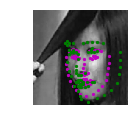

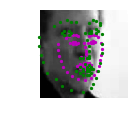

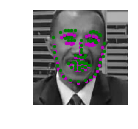

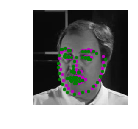

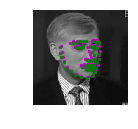

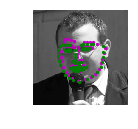

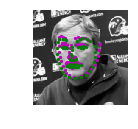

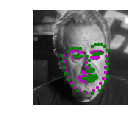

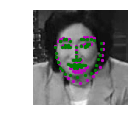

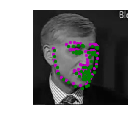

In [20]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [21]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.14087664  0.00026138  0.00092195 -0.00678944 -0.03119133]
 [-0.16511799 -0.10242125  0.10440294  0.13655391  0.15202756]
 [-0.12547582 -0.17563608  0.11654438 -0.11073948 -0.17591146]
 [-0.13789624  0.15773834  0.11126735  0.19038054 -0.0698802 ]
 [-0.15257479  0.06424697 -0.14669918  0.14895321 -0.08701662]]
(5, 5)


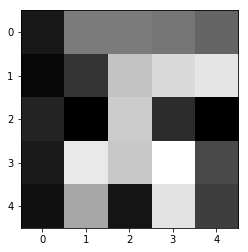

In [22]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!